<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 4.4: Regularisation

In [29]:
## Import Libraries

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

## Avoid some version change warnings
import warnings
warnings.filterwarnings('ignore', message='numpy.dtype size changed')

### 1. Regularisation

The goal of "regularizing" regression models is to structurally prevent overfitting by imposing a penalty on the coefficients of the model.

Regularization methods like the Ridge and Lasso add this additional "penalty" on the size of coefficients to the loss function. When the loss function is minimized, this additional component is added to the residual sum of squares.

In other words, the minimization becomes a balance between the error between predictions and true values and the size of the coefficients. 

The two most common types of regularization are the **Lasso**, **Ridge**. 

#### 1.1 Load Diabetics Data Using datasets of sklearn

Hint: Check Lab 4.3

In [30]:
## Load the Diabetes dataset
Diabetes = pd.read_csv("diabetes.csv")

# Load the diabetes dataset from sklearn
diabetes = datasets.load_diabetes()



In [31]:
# Description
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

In [32]:
diabetes.data

array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
         0.01990842, -0.01764613],
       [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
        -0.06832974, -0.09220405],
       [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
         0.00286377, -0.02593034],
       ...,
       [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
        -0.04687948,  0.01549073],
       [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
         0.04452837, -0.02593034],
       [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
        -0.00421986,  0.00306441]])

In [35]:
# Predictors
X = pd.DataFrame(diabetes.data, columns = diabetes.feature_names)

In [36]:
# Target
y = diabetes.target

#### 1.2 Create a Base Model Using Linear Regression

In [62]:
# Create Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
lm = LinearRegression()

In [63]:
# Fit
model = lm.fit(X_train,y_train)

In [64]:
predictions= lm.predict(X_test)

#### Checking whether the model is overfitted/underfitted or perfect

In [76]:
#  Trainnig Score Linear Model
print("model score of trained set :",model.score(X_train,y_train))

model score of trained set : 0.5341751875813193


In [77]:
# Test Score Linear Model
print("model score of test set :", model.score(X_test,y_test))

model score of test set : 0.45767674177195594


It seems to be the model is **overfitted**.Because the **trained score > the test score**

### Model Evaluation
#### There are 3 main metrics for model evaluation in regression:
R Square /Adjusted R Square.

Mean Square Error(MSE)/Root Mean Square Error(RMSE) 

Mean Absolute Error(MAE)

In [84]:
from sklearn import metrics
r2 = metrics.r2_score(y_test, predictions)
print("R2 :", metrics.r2_score(y_test, predictions))    
adj_r2 = (1 - (1 - r2) * ((X_train.shape[0] - 1) / 
          (X_train.shape[0] - X_train.shape[1] - 1)))
print("Adjusted r2 : " ,adj_r2 )

print('MAE  (Mean Absolute Error) :', metrics.mean_absolute_error(y_test, predictions))
print('MSE  (MeanSquared Error) :', metrics.mean_squared_error(y_test, predictions))
print('RMSE (Root Mean Squared Error) :', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

R2 : 0.45767674177195594
Adjusted r2 :  0.4394779747173235
MAE  (Mean Absolute Error) : 46.021951395698274
MSE  (MeanSquared Error) : 3365.0759915425374
RMSE (Root Mean Squared Error) : 58.00927504755199


### Viewing the coefficients of the basic reggression model .

In [21]:
def view_coeff(X, model):
    model_coefs = pd.DataFrame({'variable': X.columns,
                                'coef': model.coef_,
                                'abs_coef': np.abs(model.coef_)})
    model_coefs.sort_values('abs_coef', inplace=True, ascending=False)
    sns.barplot(x="variable", y="coef", data=model_coefs)

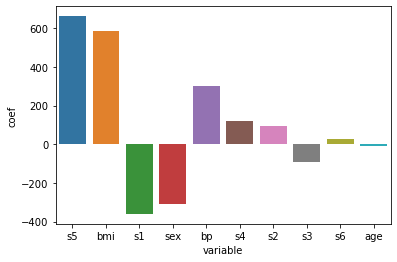

In [22]:
# Plot Coefficients
view_coeff(X, model)

In [58]:
# Check Coefficent
coeff_df = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
age,-8.025664
sex,-308.839450
bmi,583.630743
bp,299.997618
s1,-360.689402
s2,95.142352
s3,-93.033068
s4,118.150056
s5,662.128877
s6,26.074016


In [85]:
## Though the model is overfitted we use Ridge and Lasso Regression model.

#### 1.3 Ridge

##### 1.3.1 Calculate Ridge Regression model

In [97]:
## Calculate Ridge Regression model

# create a model object to hold the modelling parameters
rrm = Ridge()

# keep track of the intermediate results for coefficients and errors
coefs = []
errors = []

# create a range of alphas to calculate
ridge_alphas = np.logspace(-6, 6, 200)

# Train the model with different regularisation strengths
for a in ridge_alphas:
    rrm.set_params(alpha = a)
    rrm.fit(X, y)
    coefs.append(rrm.coef_)
    errors.append(mean_squared_error(rrm.coef_, model.coef_))
   

##### 1.3.2 Visual Representation of Coefficient of Ridge Model

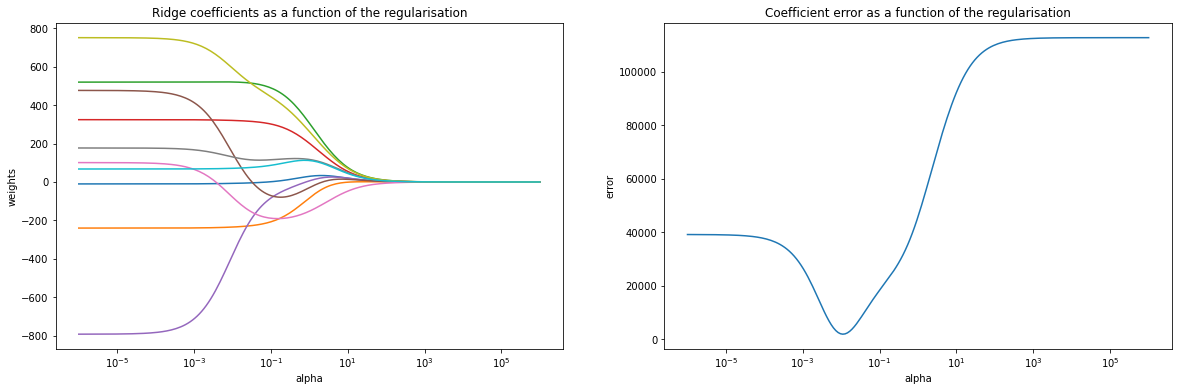

In [42]:
# Display results
plt.figure(figsize = (20, 6))

plt.subplot(121)
ax = plt.gca()
ax.plot(ridge_alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularisation')
plt.axis('tight')

plt.subplot(122)
ax = plt.gca()
ax.plot(ridge_alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.title('Coefficient error as a function of the regularisation')
plt.axis('tight')

plt.show()

##### 1.3.3. [BONUS]  Find an optimal value for Ridge regression alpha using `RidgeCV`.

[Go to the documentation and read how RidgeCV works.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV).

Note here that you will be optimizing both the alpha parameter and the l1_ratio:
- `alpha`: strength of regularization

In [90]:
optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X, y)
print('Alpha:', optimal_ridge.alpha_)
print('Score:', optimal_ridge.score(X, y))

Alpha: 0.06669919663030115
Score: 0.5138362231730855


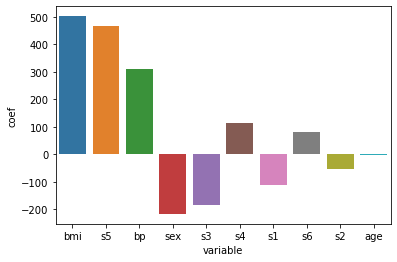

In [91]:
view_coeff(X, optimal_ridge)

In [104]:
coeff_df = pd.DataFrame(optimal_ridge.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
age,-1.266227
sex,-216.397220
bmi,501.545252
bp,308.138306
s1,-112.184365
s2,-54.473215
s3,-182.303962
s4,114.031935
s5,466.755330
s6,81.943177


#### 1.4 Lasso

##### 1.4.1 Calculate Lasso Regression model

In [49]:
## Calculate Lasso Regression model


In [98]:
# create a model object to hold the modelling parameters
lrm=Lasso()
# keep track of the intermediate results for coefficients and errors
coefs = []
errors = []
# create a range of alphas to calculate
lasso_alphas = np.logspace(-6, 6, 200)
# Train the model with different regularisation strengths
for a in lasso_alphas:
    lrm.set_params(alpha = a)
    lrm.fit(X, y)
    coefs.append(lrm.coef_)
    errors.append(mean_squared_error(lrm.coef_, model.coef_))

##### 1.4.2 Visual Representation of Coefficient of Lasso Model

Hint: Same as Ridge

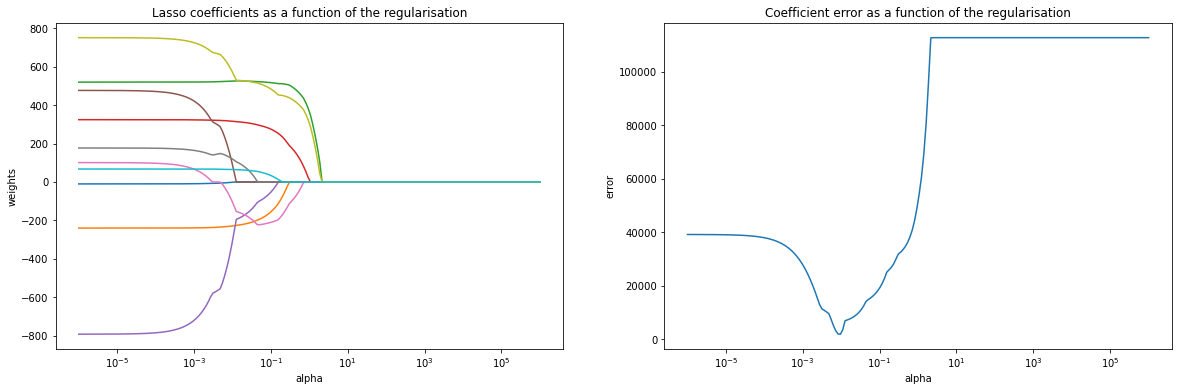

In [99]:
# Display results
# Display results
plt.figure(figsize = (20, 6))

plt.subplot(121)
ax = plt.gca()
ax.plot(lasso_alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularisation')
plt.axis('tight')

plt.subplot(122)
ax = plt.gca()
ax.plot(lasso_alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.title('Coefficient error as a function of the regularisation')
plt.axis('tight')

plt.show()

##### 1.4.3. [BONUS]  Find an optimal value for Lasso regression alpha using `LassoCV`.

[Go to the documentation and read how LassoCV works.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV).

Note here that you will be optimizing both the alpha parameter and the l1_ratio:
- `alpha`: strength of regularization

In [100]:
# Find Optimal Lasso Using LassoCV
optimal_lasso = LassoCV(alphas=lasso_alphas, cv=10)
optimal_lasso.fit(X, y)
print('Alpha:', optimal_lasso.alpha_)
print('Score:', optimal_lasso.score(X, y))

Alpha: 0.05805225516094896
Score: 0.512648775957248


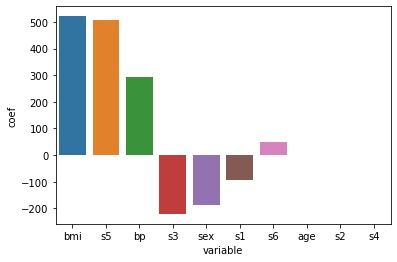

In [101]:
# Plot Coefficient
view_coeff(X, optimal_lasso)

In [105]:
coeff_df = pd.DataFrame(optimal_lasso.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
age,-0.000000
sex,-187.816230
bmi,521.074737
bp,291.980696
s1,-91.895851
s2,-0.000000
s3,-220.696639
s4,0.000000
s5,507.518201
s6,49.824582


### 2. [Bonus] Compare the residuals for the Ridge and Lasso visually.

Find and create sctterplot for both Ridge and Lasso residuals.

In [106]:
# Build the ridge and lasso using optimal alpha
ridge = Ridge(alpha=optimal_ridge.alpha_)
lasso = Lasso(alpha=optimal_lasso.alpha_)

# Need to fit the Lasso and Ridge outside of cross_val_score like we did with the ridge
ridge.fit(X, y)
lasso.fit(X, y)

Lasso(alpha=0.05805225516094896)

In [107]:
# model residuals:
ridge_resid = y - ridge.predict(X)
lasso_resid = y - lasso.predict(X)

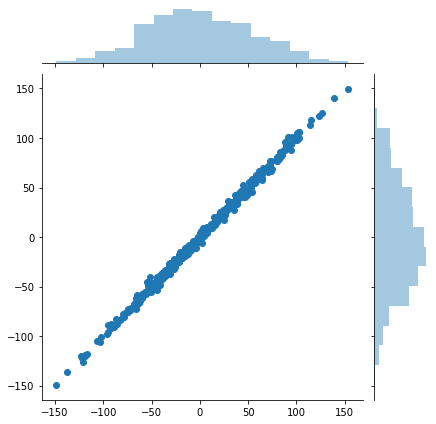

In [108]:
# Jointplot
sns.jointplot(ridge_resid, lasso_resid);



---



---



> > > > > > > > > © 2019 Institute of Data


---



---





from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
X, y = make_friedman1(n_samples=50, n_features=10, random_state=0)
estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X, y)
selector.support_

selector.ranking_

